<img src="opendata-top-transblack.png" style="width:50%">

# A Z prime boson analysis notebook in python
### In this notebook you can find a program that shows even more high energy physics (HEP) analysis techniques. It is an analysis searching for events where so called hypothetical [Z-prime bosons](https://en.wikipedia.org/wiki/W'_and_Z'_bosons) decay into a top-antitop pair that decays into other particles.

<img src="Z-prime Zerfall.PNG" style="width:50%">

So first of all - like we did it in the first notebook - ROOT is imported to read the so called _.root_ data. Moreover _math_ is imported to help during the analysis.

In [25]:
import ROOT
import math

In order to activate the interactive visualisation of the histogram that is later created we can use the JSROOT magic:

In [33]:
%jsroot on

Next we have to open the data that we want to analyse (_.root_-file).

In [26]:
#f = ROOT.TFile.Open("http://opendata.atlas.cern/release/samples/MC/mc_147770.Zee.root")
f = ROOT.TFile.Open("mc_105986.ZZ.root")

After the data is opened we create a canvas _c_ on which we can draw a histogram.

In [27]:
c = ROOT.TCanvas("Canvas","Z-prime boson Analysis",800,1500)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


In [28]:
t = f.Get("mini")

Now we define a histogram that is later lying on this canvas. Its name is _variable_ and the header of the histogram is _Example plot: Mass of the Z boson_. The three following numbers say that this histogram contains of 100 so called bins that are going from 50 to 130.

In [29]:
h1 = ROOT.TH1F("variable","etmiss",30,0,500)
h2 = ROOT.TH1F("variable","n_b_jets",5,0,5)
h3 = ROOT.TH1F("variable","mTW",30,0,150)
h4 = ROOT.TH1F("variable","mWhadr",30,0,150)
h5 = ROOT.TH1F("variable","varmassWhadr",15,0,60)
h6 = ROOT.TH1F("variable","disttt",30,0,4)
h7 = ROOT.TH1F("variable","masstophadr",50,0,500)
h8 = ROOT.TH1F("variable","M1T",50,0,3000)

Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: variable (Potential memory leak).


In [ ]:
def goodLeptons

def goodJets

The following lines are a loop that goes over the data and fills the tree _t_ that we already defined. We also do some cuts to select only the interesting data.

In [30]:
for event in t:
    if not (t.met_et > 150): continue
    
    # apply standard event based selection
    #if not AH.StandardEventCuts(eventinfo): continue
    
    # Lepton Requirements
    if not (t.lep_n == 1): continue
    
    # Jet Requirements
    if not (t.jet_n >= 4): continue
    
    # b-tag
    n_b_jets = sum([1 for jet in goodJets if t.jet_MV1 >= 0.7892])
    if n_b_jets != 1 and n_b_jets != 2: continue
    
    #Creating 2 lists: one with all b-Jets, the other with all other jets
    b_jets = []
    light_jets = []
    for jet in goodJets:
        if jet.mv1() >= 0.7892:
            b_jets.append(jet)
        else: light_jets.append(jet)

    #list for calculating invariant mass
    signal_jets = b_jets + light_jets
    signal_jets = signal_jets[0:4]

    lepton = goodLeptons[0]
    mTW = math.sqrt(2*t.lep_pt*t.met_et*(1-math.cos(lepton.tlv().DeltaPhi(t.met_et.tlv()))))
    if not mTW > 30: continue;
    if not mTW + t.met_et.et() > 60: continue

    # reconstruction of hadronic W
    if len(b_jets) == 1:
        variation = None # current smallest Wmass variation from jet masses
        bjet1 = b_jets[0].tlv()
        for (i,j) in [[0,1],[0,2],[1,2]]:
            Wmassvar = abs((light_jets[i].tlv() + light_jets[j].tlv()).M() - 80.4)
            if variation == None or Wmassvar < variation:
                variation = Wmassvar
                indice = [0,1,2]
                indice.remove(i)
                indice.remove(j)
                bjet2 = light_jets[indice[0]].tlv()
                Wjet1 = light_jets[i].tlv()
                Wjet2 = light_jets[j].tlv()
    else:
        bjet1 = b_jets[0].tlv()
        bjet2 = b_jets[1].tlv()
        Wjet1 = light_jets[0].tlv()
        Wjet2 = light_jets[1].tlv()
        variation = abs((light_jets[0].tlv() + light_jets[1].tlv()).M() - 80.4)
    Whadr = Wjet1 + Wjet2
    Wlept = lepton.tlv() + etmiss.tlv() # only properties in transverse plane because of missing pz of neutrino
    massWhadr = (Wjet1 + Wjet2).M()

    # reconstruction of the top quarks by choosing which W goes with which bottom quark
    bhadr = ROOT.TLorentzVector()
    blept = None
    dist1 = bjet1.DeltaR(Whadr)
    dist2 = bjet2.DeltaR(Whadr)
    if dist1 < dist2:
        bhadr = bjet1
        blept = bjet2
    else: #(dist2 < dist1)
        bhadr = bjet2
        blept = bjet1
    tophadr = Whadr + bhadr
    toplept = Wlept + blept
    disttt = tophadr.DeltaPhi(toplept) # DeltaPhi = angle in transverse plane
    
    # calculating transverse mass 1 (objectsum --> vector of five particles)
    objectsum = signal_jets[0].tlv() + signal_jets[1].tlv() + signal_jets[2].tlv() + signal_jets[3].tlv() + goodLeptons[0].tlv()
   
    TransverseEnergy = (math.sqrt((objectsum.M()**2) + (objectsum.Pt()**2)) + (t.met_et.tlv()).Pt())**2
    TransverseImpuls = ((objectsum + t.met_et.tlv()).Pt())**2
    M1T = math.sqrt(TransverseEnergy - TransverseImpuls)
    
    h1.Fill(t.met_et)
    h2.Fill(n_b_jets)
    h3.Fill(mTW)
    h4.Fill(Whadr.M())
    h5.Fill(variation)
    h6.Fill(disttt)
    h7.Fill(tophadr.M())
    h8.Fill(M1T)

After filling the tree we want to see the results of the analysis. So first we let draw the histogram and then the canvas on which the histogram lies.

In [31]:
c.Divide(2,4)
c.cd(1)
h1.Draw()
c.cd(2)
h2.Draw()
c.cd(3)
h3.Draw()
c.cd(4)
h4.Draw()
c.cd(5)
h5.Draw()
c.cd(6)
h6.Draw()
c.cd(7)
h7.Draw()
c.cd(8)
h8.Draw()

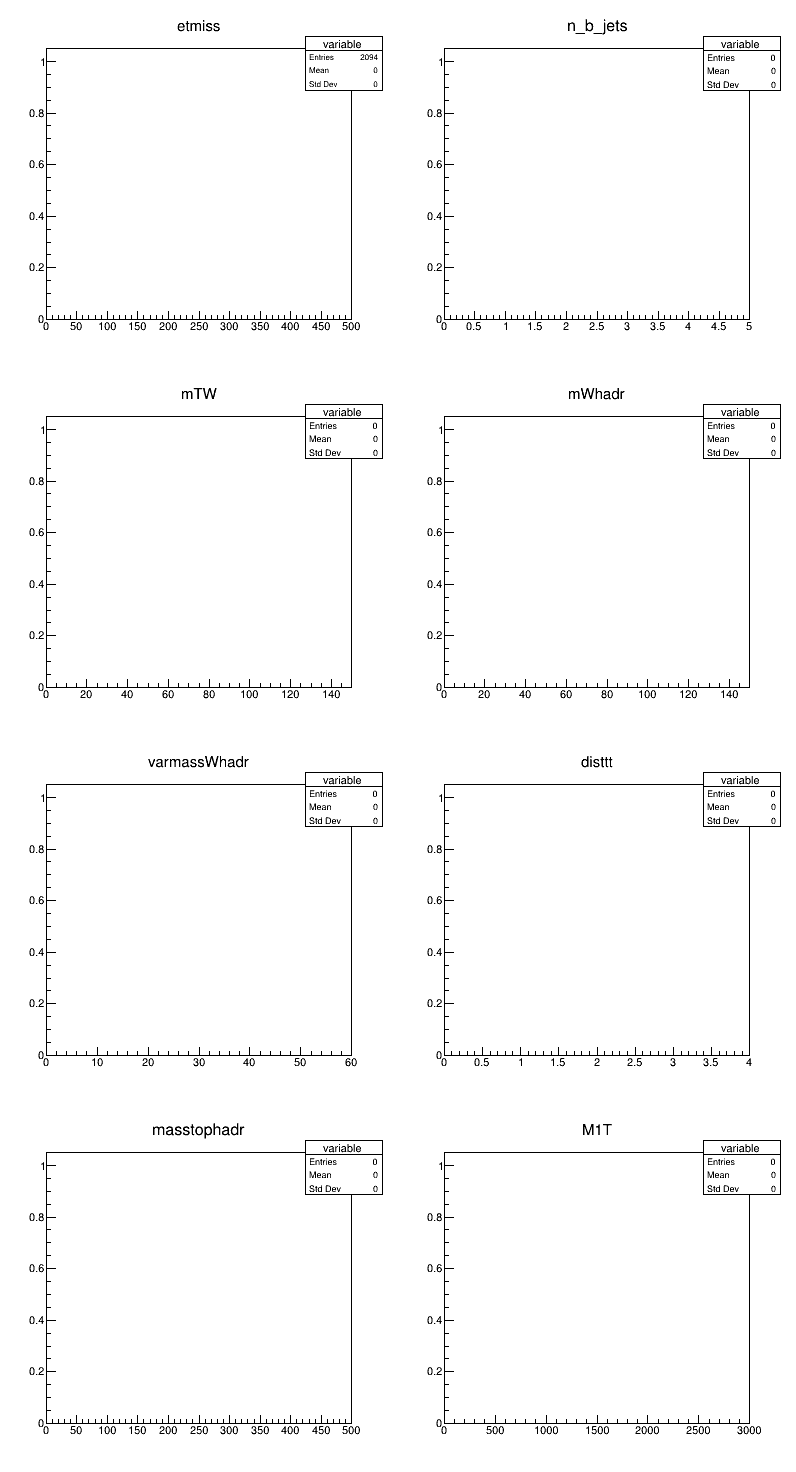

In [32]:
c.Draw()